In [1]:
import numpy as np
import pandas as pd
import os
import glob
from PIL import Image
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 20
np.random.seed(231)
from sklearn.model_selection import train_test_split
import cv2


In [2]:
train_dir = "/mnt/disks/large/data/original_train/"
data_dir = "/mnt/disks/large/data/"
output_dir = "/home/rugezhao/CS231N_CZT/data/"

In [3]:
train_df = pd.read_csv(data_dir+"train.csv", engine='python')
labels_df = pd.read_csv(data_dir+"labels.csv", engine='python')


The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2. To stratify sample the class needs at least 3 samples. So I decided to drop all samples that are tagged to a label that appeared less than 3 times.

# Data Split

In [4]:
def train_val_test_split(train_id_attribute_id, ratios = (0.8,0.1,0.1),min_count=3):
    train_id_attribute_id_ohe= np.zeros((len(train_df), len(labels_df)), dtype=int)
    for idx, attr_arr in enumerate(train_df.attribute_ids.str.split(" ").apply(lambda l: list(map(int, l))).values):
        train_id_attribute_id_ohe[idx, attr_arr] = 1
    train_id_attribute_id_ohe = pd.DataFrame(train_id_attribute_id_ohe,columns=labels_df.attribute_id)
    print("one hot encoding done")
    
    col_sum=pd.DataFrame(np.sum(train_id_attribute_id_ohe,axis=0))
    col_sum=col_sum.reset_index()
    infreq_labels = list(col_sum[col_sum.iloc[:,1] < min_count].iloc[:,0])
    print("{} infrequent labels less than {} times found".format(len(infreq_labels),min_count))
    
    # drop the examples with infreq labels, i.e. if 1 in any of these columns -->drop
    df_onehot = pd.concat([train_id_attribute_id,train_id_attribute_id_ohe], axis=1)
    df_onehot = df_onehot.drop(columns=["attribute_ids"])
    infreq_cols = df_onehot[infreq_labels]
    X_infreq = list(df_onehot.loc[(infreq_cols!=0).any(axis=1)].id)
    
    df_onehot = df_onehot[~df_onehot.id.isin(X_infreq)]
     
    X = df_onehot.id
    y = df_onehot.iloc[:,1:]
    # use stratify=y for stratified sampling -->> impossible!! since they need to treat combination of label as a class
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=ratios[2], random_state=231,stratify=None)
    print("test set done, size {}".format(X_test.shape))
    # use stratify =y_train_val for stratified sampling -->impossible!!
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=ratios[1]/(ratios[0]+ratios[1]), random_state=231,stratify=None)
    print("val set done, size {}".format(X_val.shape))
    print("train set done, size {}".format(X_train.shape))
    return X_train, X_val, X_test, X_infreq, df_onehot

In [5]:
np.random.seed(231)
X_train, X_val, X_test, X_infreq, df_onehot = train_val_test_split(train_df)

one hot encoding done
26 infrequent labels less than 3 times found
test set done, size (10920,)
val set done, size (10920,)
train set done, size (87360,)


## Check distribution

In [6]:
df_one_train = df_onehot[df_onehot.id.isin(X_train)]
df_one_val = df_onehot[df_onehot.id.isin(X_val)]
df_one_test = df_onehot[df_onehot.id.isin(X_test)]

In [7]:
df_one_train_export = train_df[train_df.id.isin(X_train)]
df_one_train_export.to_csv(output_dir+"/train_split_train.csv",index=False)
df_one_val_export = train_df[train_df.id.isin(X_val)]
df_one_val_export.to_csv(output_dir+"/train_split_val.csv",index=False)
df_one_test_export = train_df[train_df.id.isin(X_test)]
df_one_test_export.to_csv(output_dir+"/train_split_test.csv",index=False)

In [8]:
col_pct_train=pd.DataFrame(np.sum(df_one_train.iloc[:,1:],axis=0))/df_one_train.shape[0]
col_pct_val=pd.DataFrame(np.sum(df_one_val.iloc[:,1:],axis=0))/df_one_val.shape[0]
col_pct_test=pd.DataFrame(np.sum(df_one_test.iloc[:,1:],axis=0))/df_one_test.shape[0]

In [9]:
col_pct_train.sort_values(0,ascending=False)

,0
813,0.183745
1092,0.130804
147,0.124531
189,0.094677
13,0.083116
671,0.077724
51,0.070250
194,0.068098
1059,0.059879
121,0.059558


In [13]:
col_pct_train.columns=['proportion']
col_pct_train.to_csv("/mnt/disks/large/data/train_split/train_train_label_proportion.csv")

In [9]:
col_pct_val.sort_values(0,ascending=False)

,0
813,0.185623
1092,0.128480
147,0.119505
189,0.093132
13,0.088187
671,0.075000
51,0.068407
194,0.065018
1059,0.058883
121,0.058150


In [10]:
col_pct_test.sort_values(0,ascending=False)

,0
813,0.172711
1092,0.132418
147,0.122253
189,0.099451
13,0.084890
671,0.073626
194,0.067308
51,0.066575
121,0.064469
1059,0.062912


In [15]:
# export split to csv
train_df['train'] = 0
train_df['val']=0
train_df['test']=0


In [16]:
train_df.loc[train_df.id.isin(list(X_train)),'train'] = 1
train_df.loc[train_df.id.isin(list(X_val)),'val'] = 1
train_df.loc[train_df.id.isin(list(X_test)),'test'] = 1
train_df.to_csv(output_dir+"/train_split.csv",index=False)

# TODO: Change Folder Structure - move .png according to train_split.csv

In [13]:
# TODO
# import os
# train_files = os.listdir(train_dir)
src_dir = "/mnt/disks/large/data/original_train/"

train_new_dir = "/mnt/disks/large/data/train_split/"
train_split_dir = train_new_dir + "train/"
val_split_dir = train_new_dir + "val/"
test_split_dir = train_new_dir + "test/"

In [14]:
import os, shutil, pathlib, fnmatch

def move_dir(src: str, dst: str, pattern: str = '*'):
    if not os.path.isdir(dst):
        pathlib.Path(dst).mkdir(parents=True, exist_ok=True)
    for f in fnmatch.filter(os.listdir(src), pattern):
        shutil.move(os.path.join(src, f), os.path.join(dst, f))
        


In [ ]:
train_files=list(train_df[train_df.train==1].id)
train_files = [x+".png" for x in train_files]
for i,f in enumerate(train_files):
    move_dir(src_dir, train_split_dir, f)
    print("{}/{} files moved".format(i, len(train_files)))

In [ ]:
val_files=list(train_df[train_df.val==1].id)
val_files = [x+".png" for x in val_files]
for i,f in enumerate(val_files):
    move_dir(src_dir, val_split_dir, f)
    print("{}/{} files moved".format(i, len(val_files)))

In [ ]:
test_files=list(train_df[train_df.test==1].id)
test_files = [x+".png" for x in test_files]
for i,f in enumerate(test_files):
    move_dir(src_dir, test_split_dir, f)
    print("{}/{} files moved".format(i, len(test_files)))

# Training preprocessing

In [ ]:
# pause for now since it can be done at run time using pytorch
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Val, Test Preprocessing

In [ ]:
# pause for now since it can be done at run time using pytorch
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Training Per Channel Mean and Std - after preprocessing

In [9]:
# import os
# train_files = os.listdir(train_dir)
# do not use folder structure, use the newly created training data

#train_files=list(train_df[train_df.train==1].id)
train_split_dir = '/mnt/disks/large/data/train_split/train'
train_split_csv = '/mnt/disks/large/data/train_split/train_split_train.csv'
train_split_df = pd.read_csv(train_split_csv, engine='python')
train_files=list(train_split_df.id)
train_files = [x+".png" for x in train_files]
print(len(train_files))

87360


In [11]:
sum_x_rgb = np.array([0.0]*3)
sum_x2_rgb = np.array([0.0]*3)
file_count =0
pixel_count=0
for i, file in enumerate(train_files):
    if i%10==0:
        print("{}/{} files read".format(i+1, len(train_files)))
    file_count+=1
    
    image = cv2.imread(train_split_dir+"/"+file)
    pixel_count += image.shape[0]*image.shape[1]
    # R, G, B
    for i in range(3):
        pixel_val = image[:,:,i].astype(float) / 255 # scaling because Pytorch transform ToTensor will scale
        sum_x_rgb[i] += np.sum(pixel_val)
        sum_x2_rgb[i] += np.sum(pixel_val**2)
        
        

1/87360 files read
11/87360 files read
21/87360 files read
31/87360 files read
41/87360 files read
51/87360 files read
61/87360 files read
71/87360 files read
81/87360 files read
91/87360 files read
101/87360 files read
111/87360 files read
121/87360 files read
131/87360 files read
141/87360 files read
151/87360 files read
161/87360 files read
171/87360 files read
181/87360 files read
191/87360 files read
201/87360 files read
211/87360 files read
221/87360 files read
231/87360 files read
241/87360 files read
251/87360 files read
261/87360 files read
271/87360 files read
281/87360 files read
291/87360 files read
301/87360 files read
311/87360 files read
321/87360 files read
331/87360 files read
341/87360 files read
351/87360 files read
361/87360 files read
371/87360 files read
381/87360 files read
391/87360 files read
401/87360 files read
411/87360 files read
421/87360 files read
431/87360 files read
441/87360 files read
451/87360 files read
461/87360 files read
471/87360 files read
481

3781/87360 files read
3791/87360 files read
3801/87360 files read
3811/87360 files read
3821/87360 files read
3831/87360 files read
3841/87360 files read
3851/87360 files read
3861/87360 files read
3871/87360 files read
3881/87360 files read
3891/87360 files read
3901/87360 files read
3911/87360 files read
3921/87360 files read
3931/87360 files read
3941/87360 files read
3951/87360 files read
3961/87360 files read
3971/87360 files read
3981/87360 files read
3991/87360 files read
4001/87360 files read
4011/87360 files read
4021/87360 files read
4031/87360 files read
4041/87360 files read
4051/87360 files read
4061/87360 files read
4071/87360 files read
4081/87360 files read
4091/87360 files read
4101/87360 files read
4111/87360 files read
4121/87360 files read
4131/87360 files read
4141/87360 files read
4151/87360 files read
4161/87360 files read
4171/87360 files read
4181/87360 files read
4191/87360 files read
4201/87360 files read
4211/87360 files read
4221/87360 files read
4231/87360

7511/87360 files read
7521/87360 files read
7531/87360 files read
7541/87360 files read
7551/87360 files read
7561/87360 files read
7571/87360 files read
7581/87360 files read
7591/87360 files read
7601/87360 files read
7611/87360 files read
7621/87360 files read
7631/87360 files read
7641/87360 files read
7651/87360 files read
7661/87360 files read
7671/87360 files read
7681/87360 files read
7691/87360 files read
7701/87360 files read
7711/87360 files read
7721/87360 files read
7731/87360 files read
7741/87360 files read
7751/87360 files read
7761/87360 files read
7771/87360 files read
7781/87360 files read
7791/87360 files read
7801/87360 files read
7811/87360 files read
7821/87360 files read
7831/87360 files read
7841/87360 files read
7851/87360 files read
7861/87360 files read
7871/87360 files read
7881/87360 files read
7891/87360 files read
7901/87360 files read
7911/87360 files read
7921/87360 files read
7931/87360 files read
7941/87360 files read
7951/87360 files read
7961/87360

11211/87360 files read
11221/87360 files read
11231/87360 files read
11241/87360 files read
11251/87360 files read
11261/87360 files read
11271/87360 files read
11281/87360 files read
11291/87360 files read
11301/87360 files read
11311/87360 files read
11321/87360 files read
11331/87360 files read
11341/87360 files read
11351/87360 files read
11361/87360 files read
11371/87360 files read
11381/87360 files read
11391/87360 files read
11401/87360 files read
11411/87360 files read
11421/87360 files read
11431/87360 files read
11441/87360 files read
11451/87360 files read
11461/87360 files read
11471/87360 files read
11481/87360 files read
11491/87360 files read
11501/87360 files read
11511/87360 files read
11521/87360 files read
11531/87360 files read
11541/87360 files read
11551/87360 files read
11561/87360 files read
11571/87360 files read
11581/87360 files read
11591/87360 files read
11601/87360 files read
11611/87360 files read
11621/87360 files read
11631/87360 files read
11641/87360

14781/87360 files read
14791/87360 files read
14801/87360 files read
14811/87360 files read
14821/87360 files read
14831/87360 files read
14841/87360 files read
14851/87360 files read
14861/87360 files read
14871/87360 files read
14881/87360 files read
14891/87360 files read
14901/87360 files read
14911/87360 files read
14921/87360 files read
14931/87360 files read
14941/87360 files read
14951/87360 files read
14961/87360 files read
14971/87360 files read
14981/87360 files read
14991/87360 files read
15001/87360 files read
15011/87360 files read
15021/87360 files read
15031/87360 files read
15041/87360 files read
15051/87360 files read
15061/87360 files read
15071/87360 files read
15081/87360 files read
15091/87360 files read
15101/87360 files read
15111/87360 files read
15121/87360 files read
15131/87360 files read
15141/87360 files read
15151/87360 files read
15161/87360 files read
15171/87360 files read
15181/87360 files read
15191/87360 files read
15201/87360 files read
15211/87360

18351/87360 files read
18361/87360 files read
18371/87360 files read
18381/87360 files read
18391/87360 files read
18401/87360 files read
18411/87360 files read
18421/87360 files read
18431/87360 files read
18441/87360 files read
18451/87360 files read
18461/87360 files read
18471/87360 files read
18481/87360 files read
18491/87360 files read
18501/87360 files read
18511/87360 files read
18521/87360 files read
18531/87360 files read
18541/87360 files read
18551/87360 files read
18561/87360 files read
18571/87360 files read
18581/87360 files read
18591/87360 files read
18601/87360 files read
18611/87360 files read
18621/87360 files read
18631/87360 files read
18641/87360 files read
18651/87360 files read
18661/87360 files read
18671/87360 files read
18681/87360 files read
18691/87360 files read
18701/87360 files read
18711/87360 files read
18721/87360 files read
18731/87360 files read
18741/87360 files read
18751/87360 files read
18761/87360 files read
18771/87360 files read
18781/87360

21951/87360 files read
21961/87360 files read
21971/87360 files read
21981/87360 files read
21991/87360 files read
22001/87360 files read
22011/87360 files read
22021/87360 files read
22031/87360 files read
22041/87360 files read
22051/87360 files read
22061/87360 files read
22071/87360 files read
22081/87360 files read
22091/87360 files read
22101/87360 files read
22111/87360 files read
22121/87360 files read
22131/87360 files read
22141/87360 files read
22151/87360 files read
22161/87360 files read
22171/87360 files read
22181/87360 files read
22191/87360 files read
22201/87360 files read
22211/87360 files read
22221/87360 files read
22231/87360 files read
22241/87360 files read
22251/87360 files read
22261/87360 files read
22271/87360 files read
22281/87360 files read
22291/87360 files read
22301/87360 files read
22311/87360 files read
22321/87360 files read
22331/87360 files read
22341/87360 files read
22351/87360 files read
22361/87360 files read
22371/87360 files read
22381/87360

25531/87360 files read
25541/87360 files read
25551/87360 files read
25561/87360 files read
25571/87360 files read
25581/87360 files read
25591/87360 files read
25601/87360 files read
25611/87360 files read
25621/87360 files read
25631/87360 files read
25641/87360 files read
25651/87360 files read
25661/87360 files read
25671/87360 files read
25681/87360 files read
25691/87360 files read
25701/87360 files read
25711/87360 files read
25721/87360 files read
25731/87360 files read
25741/87360 files read
25751/87360 files read
25761/87360 files read
25771/87360 files read
25781/87360 files read
25791/87360 files read
25801/87360 files read
25811/87360 files read
25821/87360 files read
25831/87360 files read
25841/87360 files read
25851/87360 files read
25861/87360 files read
25871/87360 files read
25881/87360 files read
25891/87360 files read
25901/87360 files read
25911/87360 files read
25921/87360 files read
25931/87360 files read
25941/87360 files read
25951/87360 files read
25961/87360

29111/87360 files read
29121/87360 files read
29131/87360 files read
29141/87360 files read
29151/87360 files read
29161/87360 files read
29171/87360 files read
29181/87360 files read
29191/87360 files read
29201/87360 files read
29211/87360 files read
29221/87360 files read
29231/87360 files read
29241/87360 files read
29251/87360 files read
29261/87360 files read
29271/87360 files read
29281/87360 files read
29291/87360 files read
29301/87360 files read
29311/87360 files read
29321/87360 files read
29331/87360 files read
29341/87360 files read
29351/87360 files read
29361/87360 files read
29371/87360 files read
29381/87360 files read
29391/87360 files read
29401/87360 files read
29411/87360 files read
29421/87360 files read
29431/87360 files read
29441/87360 files read
29451/87360 files read
29461/87360 files read
29471/87360 files read
29481/87360 files read
29491/87360 files read
29501/87360 files read
29511/87360 files read
29521/87360 files read
29531/87360 files read
29541/87360

32691/87360 files read
32701/87360 files read
32711/87360 files read
32721/87360 files read
32731/87360 files read
32741/87360 files read
32751/87360 files read
32761/87360 files read
32771/87360 files read
32781/87360 files read
32791/87360 files read
32801/87360 files read
32811/87360 files read
32821/87360 files read
32831/87360 files read
32841/87360 files read
32851/87360 files read
32861/87360 files read
32871/87360 files read
32881/87360 files read
32891/87360 files read
32901/87360 files read
32911/87360 files read
32921/87360 files read
32931/87360 files read
32941/87360 files read
32951/87360 files read
32961/87360 files read
32971/87360 files read
32981/87360 files read
32991/87360 files read
33001/87360 files read
33011/87360 files read
33021/87360 files read
33031/87360 files read
33041/87360 files read
33051/87360 files read
33061/87360 files read
33071/87360 files read
33081/87360 files read
33091/87360 files read
33101/87360 files read
33111/87360 files read
33121/87360

36271/87360 files read
36281/87360 files read
36291/87360 files read
36301/87360 files read
36311/87360 files read
36321/87360 files read
36331/87360 files read
36341/87360 files read
36351/87360 files read
36361/87360 files read
36371/87360 files read
36381/87360 files read
36391/87360 files read
36401/87360 files read
36411/87360 files read
36421/87360 files read
36431/87360 files read
36441/87360 files read
36451/87360 files read
36461/87360 files read
36471/87360 files read
36481/87360 files read
36491/87360 files read
36501/87360 files read
36511/87360 files read
36521/87360 files read
36531/87360 files read
36541/87360 files read
36551/87360 files read
36561/87360 files read
36571/87360 files read
36581/87360 files read
36591/87360 files read
36601/87360 files read
36611/87360 files read
36621/87360 files read
36631/87360 files read
36641/87360 files read
36651/87360 files read
36661/87360 files read
36671/87360 files read
36681/87360 files read
36691/87360 files read
36701/87360

39871/87360 files read
39881/87360 files read
39891/87360 files read
39901/87360 files read
39911/87360 files read
39921/87360 files read
39931/87360 files read
39941/87360 files read
39951/87360 files read
39961/87360 files read
39971/87360 files read
39981/87360 files read
39991/87360 files read
40001/87360 files read
40011/87360 files read
40021/87360 files read
40031/87360 files read
40041/87360 files read
40051/87360 files read
40061/87360 files read
40071/87360 files read
40081/87360 files read
40091/87360 files read
40101/87360 files read
40111/87360 files read
40121/87360 files read
40131/87360 files read
40141/87360 files read
40151/87360 files read
40161/87360 files read
40171/87360 files read
40181/87360 files read
40191/87360 files read
40201/87360 files read
40211/87360 files read
40221/87360 files read
40231/87360 files read
40241/87360 files read
40251/87360 files read
40261/87360 files read
40271/87360 files read
40281/87360 files read
40291/87360 files read
40301/87360

43441/87360 files read
43451/87360 files read
43461/87360 files read
43471/87360 files read
43481/87360 files read
43491/87360 files read
43501/87360 files read
43511/87360 files read
43521/87360 files read
43531/87360 files read
43541/87360 files read
43551/87360 files read
43561/87360 files read
43571/87360 files read
43581/87360 files read
43591/87360 files read
43601/87360 files read
43611/87360 files read
43621/87360 files read
43631/87360 files read
43641/87360 files read
43651/87360 files read
43661/87360 files read
43671/87360 files read
43681/87360 files read
43691/87360 files read
43701/87360 files read
43711/87360 files read
43721/87360 files read
43731/87360 files read
43741/87360 files read
43751/87360 files read
43761/87360 files read
43771/87360 files read
43781/87360 files read
43791/87360 files read
43801/87360 files read
43811/87360 files read
43821/87360 files read
43831/87360 files read
43841/87360 files read
43851/87360 files read
43861/87360 files read
43871/87360

47021/87360 files read
47031/87360 files read
47041/87360 files read
47051/87360 files read
47061/87360 files read
47071/87360 files read
47081/87360 files read
47091/87360 files read
47101/87360 files read
47111/87360 files read
47121/87360 files read
47131/87360 files read
47141/87360 files read
47151/87360 files read
47161/87360 files read
47171/87360 files read
47181/87360 files read
47191/87360 files read
47201/87360 files read
47211/87360 files read
47221/87360 files read
47231/87360 files read
47241/87360 files read
47251/87360 files read
47261/87360 files read
47271/87360 files read
47281/87360 files read
47291/87360 files read
47301/87360 files read
47311/87360 files read
47321/87360 files read
47331/87360 files read
47341/87360 files read
47351/87360 files read
47361/87360 files read
47371/87360 files read
47381/87360 files read
47391/87360 files read
47401/87360 files read
47411/87360 files read
47421/87360 files read
47431/87360 files read
47441/87360 files read
47451/87360

50621/87360 files read
50631/87360 files read
50641/87360 files read
50651/87360 files read
50661/87360 files read
50671/87360 files read
50681/87360 files read
50691/87360 files read
50701/87360 files read
50711/87360 files read
50721/87360 files read
50731/87360 files read
50741/87360 files read
50751/87360 files read
50761/87360 files read
50771/87360 files read
50781/87360 files read
50791/87360 files read
50801/87360 files read
50811/87360 files read
50821/87360 files read
50831/87360 files read
50841/87360 files read
50851/87360 files read
50861/87360 files read
50871/87360 files read
50881/87360 files read
50891/87360 files read
50901/87360 files read
50911/87360 files read
50921/87360 files read
50931/87360 files read
50941/87360 files read
50951/87360 files read
50961/87360 files read
50971/87360 files read
50981/87360 files read
50991/87360 files read
51001/87360 files read
51011/87360 files read
51021/87360 files read
51031/87360 files read
51041/87360 files read
51051/87360

54191/87360 files read
54201/87360 files read
54211/87360 files read
54221/87360 files read
54231/87360 files read
54241/87360 files read
54251/87360 files read
54261/87360 files read
54271/87360 files read
54281/87360 files read
54291/87360 files read
54301/87360 files read
54311/87360 files read
54321/87360 files read
54331/87360 files read
54341/87360 files read
54351/87360 files read
54361/87360 files read
54371/87360 files read
54381/87360 files read
54391/87360 files read
54401/87360 files read
54411/87360 files read
54421/87360 files read
54431/87360 files read
54441/87360 files read
54451/87360 files read
54461/87360 files read
54471/87360 files read
54481/87360 files read
54491/87360 files read
54501/87360 files read
54511/87360 files read
54521/87360 files read
54531/87360 files read
54541/87360 files read
54551/87360 files read
54561/87360 files read
54571/87360 files read
54581/87360 files read
54591/87360 files read
54601/87360 files read
54611/87360 files read
54621/87360

57781/87360 files read
57791/87360 files read
57801/87360 files read
57811/87360 files read
57821/87360 files read
57831/87360 files read
57841/87360 files read
57851/87360 files read
57861/87360 files read
57871/87360 files read
57881/87360 files read
57891/87360 files read
57901/87360 files read
57911/87360 files read
57921/87360 files read
57931/87360 files read
57941/87360 files read
57951/87360 files read
57961/87360 files read
57971/87360 files read
57981/87360 files read
57991/87360 files read
58001/87360 files read
58011/87360 files read
58021/87360 files read
58031/87360 files read
58041/87360 files read
58051/87360 files read
58061/87360 files read
58071/87360 files read
58081/87360 files read
58091/87360 files read
58101/87360 files read
58111/87360 files read
58121/87360 files read
58131/87360 files read
58141/87360 files read
58151/87360 files read
58161/87360 files read
58171/87360 files read
58181/87360 files read
58191/87360 files read
58201/87360 files read
58211/87360

61351/87360 files read
61361/87360 files read
61371/87360 files read
61381/87360 files read
61391/87360 files read
61401/87360 files read
61411/87360 files read
61421/87360 files read
61431/87360 files read
61441/87360 files read
61451/87360 files read
61461/87360 files read
61471/87360 files read
61481/87360 files read
61491/87360 files read
61501/87360 files read
61511/87360 files read
61521/87360 files read
61531/87360 files read
61541/87360 files read
61551/87360 files read
61561/87360 files read
61571/87360 files read
61581/87360 files read
61591/87360 files read
61601/87360 files read
61611/87360 files read
61621/87360 files read
61631/87360 files read
61641/87360 files read
61651/87360 files read
61661/87360 files read
61671/87360 files read
61681/87360 files read
61691/87360 files read
61701/87360 files read
61711/87360 files read
61721/87360 files read
61731/87360 files read
61741/87360 files read
61751/87360 files read
61761/87360 files read
61771/87360 files read
61781/87360

64931/87360 files read
64941/87360 files read
64951/87360 files read
64961/87360 files read
64971/87360 files read
64981/87360 files read
64991/87360 files read
65001/87360 files read
65011/87360 files read
65021/87360 files read
65031/87360 files read
65041/87360 files read
65051/87360 files read
65061/87360 files read
65071/87360 files read
65081/87360 files read
65091/87360 files read
65101/87360 files read
65111/87360 files read
65121/87360 files read
65131/87360 files read
65141/87360 files read
65151/87360 files read
65161/87360 files read
65171/87360 files read
65181/87360 files read
65191/87360 files read
65201/87360 files read
65211/87360 files read
65221/87360 files read
65231/87360 files read
65241/87360 files read
65251/87360 files read
65261/87360 files read
65271/87360 files read
65281/87360 files read
65291/87360 files read
65301/87360 files read
65311/87360 files read
65321/87360 files read
65331/87360 files read
65341/87360 files read
65351/87360 files read
65361/87360

68521/87360 files read
68531/87360 files read
68541/87360 files read
68551/87360 files read
68561/87360 files read
68571/87360 files read
68581/87360 files read
68591/87360 files read
68601/87360 files read
68611/87360 files read
68621/87360 files read
68631/87360 files read
68641/87360 files read
68651/87360 files read
68661/87360 files read
68671/87360 files read
68681/87360 files read
68691/87360 files read
68701/87360 files read
68711/87360 files read
68721/87360 files read
68731/87360 files read
68741/87360 files read
68751/87360 files read
68761/87360 files read
68771/87360 files read
68781/87360 files read
68791/87360 files read
68801/87360 files read
68811/87360 files read
68821/87360 files read
68831/87360 files read
68841/87360 files read
68851/87360 files read
68861/87360 files read
68871/87360 files read
68881/87360 files read
68891/87360 files read
68901/87360 files read
68911/87360 files read
68921/87360 files read
68931/87360 files read
68941/87360 files read
68951/87360

72091/87360 files read
72101/87360 files read
72111/87360 files read
72121/87360 files read
72131/87360 files read
72141/87360 files read
72151/87360 files read
72161/87360 files read
72171/87360 files read
72181/87360 files read
72191/87360 files read
72201/87360 files read
72211/87360 files read
72221/87360 files read
72231/87360 files read
72241/87360 files read
72251/87360 files read
72261/87360 files read
72271/87360 files read
72281/87360 files read
72291/87360 files read
72301/87360 files read
72311/87360 files read
72321/87360 files read
72331/87360 files read
72341/87360 files read
72351/87360 files read
72361/87360 files read
72371/87360 files read
72381/87360 files read
72391/87360 files read
72401/87360 files read
72411/87360 files read
72421/87360 files read
72431/87360 files read
72441/87360 files read
72451/87360 files read
72461/87360 files read
72471/87360 files read
72481/87360 files read
72491/87360 files read
72501/87360 files read
72511/87360 files read
72521/87360

75671/87360 files read
75681/87360 files read
75691/87360 files read
75701/87360 files read
75711/87360 files read
75721/87360 files read
75731/87360 files read
75741/87360 files read
75751/87360 files read
75761/87360 files read
75771/87360 files read
75781/87360 files read
75791/87360 files read
75801/87360 files read
75811/87360 files read
75821/87360 files read
75831/87360 files read
75841/87360 files read
75851/87360 files read
75861/87360 files read
75871/87360 files read
75881/87360 files read
75891/87360 files read
75901/87360 files read
75911/87360 files read
75921/87360 files read
75931/87360 files read
75941/87360 files read
75951/87360 files read
75961/87360 files read
75971/87360 files read
75981/87360 files read
75991/87360 files read
76001/87360 files read
76011/87360 files read
76021/87360 files read
76031/87360 files read
76041/87360 files read
76051/87360 files read
76061/87360 files read
76071/87360 files read
76081/87360 files read
76091/87360 files read
76101/87360

79241/87360 files read
79251/87360 files read
79261/87360 files read
79271/87360 files read
79281/87360 files read
79291/87360 files read
79301/87360 files read
79311/87360 files read
79321/87360 files read
79331/87360 files read
79341/87360 files read
79351/87360 files read
79361/87360 files read
79371/87360 files read
79381/87360 files read
79391/87360 files read
79401/87360 files read
79411/87360 files read
79421/87360 files read
79431/87360 files read
79441/87360 files read
79451/87360 files read
79461/87360 files read
79471/87360 files read
79481/87360 files read
79491/87360 files read
79501/87360 files read
79511/87360 files read
79521/87360 files read
79531/87360 files read
79541/87360 files read
79551/87360 files read
79561/87360 files read
79571/87360 files read
79581/87360 files read
79591/87360 files read
79601/87360 files read
79611/87360 files read
79621/87360 files read
79631/87360 files read
79641/87360 files read
79651/87360 files read
79661/87360 files read
79671/87360

82841/87360 files read
82851/87360 files read
82861/87360 files read
82871/87360 files read
82881/87360 files read
82891/87360 files read
82901/87360 files read
82911/87360 files read
82921/87360 files read
82931/87360 files read
82941/87360 files read
82951/87360 files read
82961/87360 files read
82971/87360 files read
82981/87360 files read
82991/87360 files read
83001/87360 files read
83011/87360 files read
83021/87360 files read
83031/87360 files read
83041/87360 files read
83051/87360 files read
83061/87360 files read
83071/87360 files read
83081/87360 files read
83091/87360 files read
83101/87360 files read
83111/87360 files read
83121/87360 files read
83131/87360 files read
83141/87360 files read
83151/87360 files read
83161/87360 files read
83171/87360 files read
83181/87360 files read
83191/87360 files read
83201/87360 files read
83211/87360 files read
83221/87360 files read
83231/87360 files read
83241/87360 files read
83251/87360 files read
83261/87360 files read
83271/87360

86421/87360 files read
86431/87360 files read
86441/87360 files read
86451/87360 files read
86461/87360 files read
86471/87360 files read
86481/87360 files read
86491/87360 files read
86501/87360 files read
86511/87360 files read
86521/87360 files read
86531/87360 files read
86541/87360 files read
86551/87360 files read
86561/87360 files read
86571/87360 files read
86581/87360 files read
86591/87360 files read
86601/87360 files read
86611/87360 files read
86621/87360 files read
86631/87360 files read
86641/87360 files read
86651/87360 files read
86661/87360 files read
86671/87360 files read
86681/87360 files read
86691/87360 files read
86701/87360 files read
86711/87360 files read
86721/87360 files read
86731/87360 files read
86741/87360 files read
86751/87360 files read
86761/87360 files read
86771/87360 files read
86781/87360 files read
86791/87360 files read
86801/87360 files read
86811/87360 files read
86821/87360 files read
86831/87360 files read
86841/87360 files read
86851/87360

In [12]:
channel_mean = sum_x_rgb/pixel_count
channel_mean

array([0.56584825, 0.61147285, 0.6472829 ])

In [13]:
channel_sd = np.sqrt(sum_x2_rgb/pixel_count-channel_mean**2)
channel_sd

array([0.25330281, 0.25008629, 0.25073694])

# TODO:  Generate small training sample for debugging 

sample by id from large training sample

In [17]:
sample_idx = np.random.choice(train_df[train_df.train==1].shape[0], 8000)
sample_train = list(train_df[train_df.train==1].iloc[sample_idx,:].id)
sample_train_files = [x+".png" for x in sample_train]

sample_idx = np.random.choice(train_df[train_df.val==1].shape[0], 1000)
sample_val = list(train_df[train_df.val==1].iloc[sample_idx,:].id)
sample_val_files = [x+".png" for x in sample_val]

sample_idx = np.random.choice(train_df[train_df.test==1].shape[0], 1000)
sample_test = list(train_df[train_df.test==1].iloc[sample_idx,:].id)
sample_test_files = [x+".png" for x in sample_test]

In [22]:
# to folder structure and copy those files to a separate folder
def copy_dir(src: str, dst: str, pattern: str = '*'):
    if not os.path.isdir(dst):
        pathlib.Path(dst).mkdir(parents=True, exist_ok=True)
    for f in fnmatch.filter(os.listdir(src), pattern):
        shutil.copyfile(os.path.join(src, f), os.path.join(dst, f))

In [14]:
debug_sample_dir = "/mnt/disks/large/debug_data/"
train_split_dir_sample =  "/mnt/disks/large/debug_data/train"
val_split_dir_sample =  "/mnt/disks/large/debug_data/val"
test_split_dir_sample =  "/mnt/disks/large/debug_data/test"

In [ ]:
for i,f in enumerate(sample_train_files):
    copy_dir(train_split_dir,train_split_dir_sample , f)
    print("{}/{} files copied".format(i, len(sample_train_files)))

In [ ]:
for i,f in enumerate(sample_val_files):
    copy_dir(val_split_dir,val_split_dir_sample , f)
    print("{}/{} files copied".format(i, len(sample_val_files)))

In [ ]:
for i,f in enumerate(sample_test_files):
    copy_dir(test_split_dir,test_split_dir_sample , f)
    print("{}/{} files copied".format(i, len(sample_test_files)))

In [ ]:
# compute channel mean and std
sum_x_rgb = np.array([0.0]*3)
sum_x2_rgb = np.array([0.0]*3)
file_count =0
pixel_count=0
for i, file in enumerate(sample_train_files):
    if i%10==0:
        print("{}/{} files read".format(i+1, len(sample_train_files)))
    file_count+=1
    
    image = cv2.imread(train_split_dir_sample+"/"+file)
    pixel_count += image.shape[0]*image.shape[1]
    # R, G, B
    for i in range(3):
        sum_x_rgb[i] += np.sum(image[:,:,i].astype(float))
        sum_x2_rgb[i] += np.sum(image[:,:,i].astype(float)**2)
        
        

In [32]:
channel_mean = sum_x_rgb/pixel_count
channel_mean

array([144.46578057, 156.0374637 , 165.11049366])

In [33]:
channel_sd = np.sqrt(sum_x2_rgb/pixel_count-channel_mean**2)
channel_sd

array([64.50104194, 63.66100116, 63.80019134])

In [19]:
sample_train_files=os.listdir(train_split_dir_sample)
sample_val_files=os.listdir(val_split_dir_sample)
sample_test_files=os.listdir(test_split_dir_sample)

In [23]:
sample_train=[x[0:-4] for x in sample_train_files]
sample_val=[x[0:-4] for x in sample_val_files]
sample_test=[x[0:-4] for x in sample_test_files]

In [26]:
df_one_train_export = train_df[train_df.id.isin(sample_train)]
df_one_train_export.to_csv(debug_sample_dir+"/train_split_train.csv",index=False)
df_one_val_export = train_df[train_df.id.isin(sample_val)]
df_one_val_export.to_csv(debug_sample_dir+"/train_split_val.csv",index=False)
df_one_test_export = train_df[train_df.id.isin(sample_test)]
df_one_test_export.to_csv(debug_sample_dir+"/train_split_test.csv",index=False)

# Compute frequency of each class in train split

In [2]:
train_split_dir = '/mnt/disks/large/data/train_split/train'
train_split_csv = '/mnt/disks/large/data/train_split/train_split_train.csv'
label_csv = '/mnt/disks/large/data/labels.csv'
labels_df = pd.read_csv(label_csv, engine='python')
train_split_df = pd.read_csv(train_split_csv, engine='python')

In [3]:
train_label_onehot = np.zeros((len(train_split_df), len(labels_df)), dtype=int)
for idx, attr_arr in enumerate(train_split_df.attribute_ids.str.split(" ").apply(lambda l: list(map(int, l))).values):
    train_label_onehot[idx, attr_arr] = 1

In [4]:
frequencies = train_label_onehot.sum(axis=0)

In [47]:
print(len(frequencies))
print(len(train_split_df))
print(sum(frequencies == 0))
print(max(frequencies))

1103
87360
26
16052


In [42]:
pos_weights = []
for i, freq in enumerate(frequencies):
    if freq != 0.:
        pos_weights.append(float(len(train_split_df)-freq) / freq) # positive weight = (num of negative) / (num of positive)
    else:
        pos_weights.append(0)

In [58]:
pos_weights_sort = np.sort(list(set(pos_weights)))
print(pos_weights_sort[-1])
print(pos_weights_sort[:10])

87359.0
[ 0.          4.44231248  6.64505119  7.03014983  9.5622053  11.03140063
 11.86597938 13.23496823 13.68482098 15.70043969]


(array([353., 193., 121.,  84.,  59.,  37.,  28.,  28.,  13.,  31.,   0.,
         18.,  15.,   0.,  17.,   0.,  22.,   0.,   0.,  24.,   0.,   0.,
          0.,   0.,  15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         25.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  17.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          3.]),
 array([    0.  ,   873.59,  1747.18,  2620.77,  3494.36,  4367.95,
         5241.54,  6115.13,  6988.72,  7862.31,  8735.9 ,  9609.49,
        10483.08, 11356.67, 12230.26, 13103.85, 13977.44, 14851.03,
        15724.62, 16598.21, 17471.8 , 18345.39, 19218.98, 20092.57,
        20966.16, 21839.75, 22713.34, 23586.93

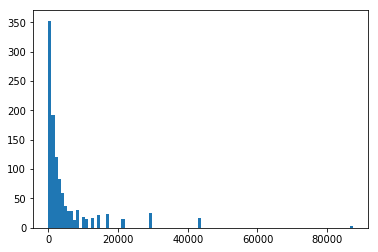

In [52]:

import matplotlib.pyplot as plt
%matplotlib inline 
pos_weights= np.array(pos_weights)
plt.hist(pos_weights, bins=100)

In [13]:
med = np.median(pos_weights)

In [14]:
print(med)

1819.0


In [37]:
from scipy.stats import mode
pos_weights_int = [round(x/10.0)*10 for x in pos_weights]
mod = mode(pos_weights_int)

In [38]:
mod

ModeResult(mode=array([0.]), count=array([27]))

In [57]:
print(np.log(3))

1.0986122886681098
